# Telco Customer Churn Tahmini

Telco şirketinin müşterilerinin sistem içerisinde kalıp kalmayacaklarını tahmin eden bir makine öğrenmesi modeli oluşturulması amaçlanmıştır.


Gerekli kütüphanelerin yüklenmesi

In [48]:
import numpy as np #lineer cebir kütüphanesi
import pandas as pd # veri işleme
import seaborn as sns
import joblib
import missingno as msno

from matplotlib import pyplot as plt
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

Dataseti yüklemek

In [49]:
data = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df=data.copy()
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Veriyi İnceleme

In [50]:
def check_df(data): # Verinin genel detaylarını gösteren fonksiyon
    print('##################### shape ##########################')
    print(data.shape)
    print('##################### type ##########################')
    print(data.dtypes)
    print('##################### null ##########################')
    print(data.isnull().sum().sort_values(ascending=False))
    print('#################### quantiles #####################')
    print(data.describe([0, 0.05, 0.5, 0.95, 0.99, 1]).T)
check_df(df)

##################### shape ##########################
(7043, 21)
##################### type ##########################
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
##################### null ##########################
customerID          0
DeviceProtection    0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
Onli

Sonuç:

-21 özellik mevcut

-Çoğu kategorik veri

-Nan değere sahip bir özellik yok

-"SeniorCitizen", "tenure", "MonthlyCharges" nümerik tipte geri kalanı kategorik veri

In [51]:
#TotalCharges tipini string değerden sayısal değere geçirme
df['TotalCharges']= pd.to_numeric(df['TotalCharges'],errors = 'coerce')
df.isnull().sum()
print(df.shape)
# Tip değişiminden sonra 11 missing değer ortaya çıktı. 11 veri DROP yedi.
df = df[df['TotalCharges'].notna()]
print(df.shape)

(7043, 21)
(7032, 21)


In [52]:
# Kaç tane kategorik veri sayısal olarak değiştirebilir ya da tam tersi mümkün mü kontrolü
def grab_col_names (dataframe, categorical = 10, cardinal =20):

    # kategorik
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == 'O']
    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtype == 'O' and
                   dataframe[col].nunique() > cardinal]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtype != 'O' and
                   dataframe[col].nunique() < categorical]
    cat_cols += num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # sayısal

    num_cols = [col for col in dataframe.columns if dataframe[col].dtype != 'O' and
                col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names (df, categorical = 10, cardinal =20)

print('Categorical Columns :',cat_cols)
print('Numerical Columns :',num_cols)
print('Numerical seemed categorical columns :',cat_but_car)

Observations: 7032
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 1
Categorical Columns : ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn', 'SeniorCitizen']
Numerical Columns : ['tenure', 'MonthlyCharges', 'TotalCharges']
Numerical seemed categorical columns : ['customerID']


Hedef Çalışması

In [53]:
# Sayısal edğişkenler ile hedef değişkenlerini karşılaştırma
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: 'mean'}))

for col in num_cols:
    target_summary_with_num(df, 'Churn', col)

# Tenure : Müşteri şirkette kaç ay kaldı.
# Churn : No: Müşteri şirkette kaldı. 
# Churn : Yes: Müşteri şirketten ayrıldı.
# Şirkette kalanlan yaklaşık 37 zaman geçirdi.
# Şirketten ayrılanlar 18 ay zaman geçirdi.
# MonthlyCharges: Aylık Ödeme
# Kalanlar aylık 61.2 ödedi
# Gidenler aylık 74.4 ödedi.

          tenure
Churn           
No     37.650010
Yes    17.979133
       MonthlyCharges
Churn                
No          61.307408
Yes         74.441332
       TotalCharges
Churn              
No      2555.344141
Yes     1531.796094


In [54]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [55]:
#Kategorik özellikler hedef değişkenle doğru şekilde karşılaştırılabilsin diye hedef değeri 'yes-no' formatından '1-0' formatına çevirme işlemi
df['Churn'] = df['Churn'].apply(lambda x: 1 if (x == 'Yes') else 0)
# Yes: Churned. Hizmeti satın almıyor. 1
# No: Not Churned. Hizmeti satın alıyor. 0

In [56]:
# Kategorik dğerleri hedef değer ile karşılaştrıma

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "Churn", col)

        TARGET_MEAN
gender             
Female     0.269595
Male       0.262046


         TARGET_MEAN
Partner             
No          0.329761
Yes         0.197171


            TARGET_MEAN
Dependents             
No             0.312791
Yes            0.155312


              TARGET_MEAN
PhoneService             
No               0.250000
Yes              0.267475


                  TARGET_MEAN
MultipleLines                
No                   0.250812
No phone service     0.250000
Yes                  0.286485


                 TARGET_MEAN
InternetService             
DSL                 0.189983
Fiber optic         0.418928
No                  0.074342


                     TARGET_MEAN
OnlineSecurity                  
No                      0.417787
No internet service     0.074342
Yes                     0.146402


                     TARGET_MEAN
OnlineBackup                    
No                      0.399417
No internet service     0.074342
Yes                     0.2156

# Özellik / Sütün Yapılandırma


In [57]:
df.head()

#Her CustomerId unique. Analize bir katkısı yok o yüzden drop 
df.drop('customerID', axis = 1, inplace = True)

In [58]:
for col in num_cols:
    target_summary_with_num(df, 'Churn', col)

df['TENURE_CAT_NEW'] = pd.cut(x= df['tenure'], bins = [-1, 1, 3, 6, 12, 24, 32, 75],
                              labels = [ 'Very_short', 'Short', 'medium1','medium2', 'medium3' , 'long1', 'long2'])
df['MONTHLY_CHARGES_NEW'] = pd.cut(x = df['MonthlyCharges'], bins = [-1, 20, 30, 55, 65, 75, 110],
                                  labels = [ 'economy', 'upper_eco', '2x_upper_eco', 'premium' , 'platinium', 'x_platinum'])
df.info()

          tenure
Churn           
0      37.650010
1      17.979133
       MonthlyCharges
Churn                
0           61.307408
1           74.441332
       TotalCharges
Churn              
0       2555.344141
1       1531.796094
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   gender               7032 non-null   object  
 1   SeniorCitizen        7032 non-null   int64   
 2   Partner              7032 non-null   object  
 3   Dependents           7032 non-null   object  
 4   tenure               7032 non-null   int64   
 5   PhoneService         7032 non-null   object  
 6   MultipleLines        7032 non-null   object  
 7   InternetService      7032 non-null   object  
 8   OnlineSecurity       7032 non-null   object  
 9   OnlineBackup         7032 non-null   object  
 10  DeviceProtection     7032 non-null   obj

In [59]:
df['Contract_Extra_Services'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)

In [60]:
# Kişinin toplam aldığı servis sayısı
df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)


# Kontratı 1 veya 2 yıllık müşterileri Engaged olarak belirtme
df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)

# Herhangi bir destek, yedek veya koruma almayan kişiler
df["NEW_noProt"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

# Aylık sözleşmesi bulunan ve genç olan müşteriler
df["NEW_Young_Not_Engaged"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)

# Herhangi bir streaming hizmeti alan kişiler
df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

# Kişi otomatik ödeme yapıyor mu?
df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)

# ortalama aylık ödeme
df["NEW_AVG_Charges"] = df["TotalCharges"] / (df["tenure"] + 1)

# Servis başına ücret
df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)

#
df.loc[(df['InternetService'] == 'DSL') | (df['InternetService'] == "Fiber optic"), 'Internet_Service'] = 1
df.loc[df['InternetService'] == 'No', 'Internet_Service'] = 0

#Yaşlı/GEnç Kadın/Erkek Ayrımı
df.loc[(df['gender'] == 'Male') & (df['SeniorCitizen'] == 1), 'AgeGender'] = 'Senior_Male'
df.loc[(df['gender'] == 'Male') & (df['SeniorCitizen'] == 0) , 'AgeGender'] = 'Young_Male'
df.loc[(df['gender'] == 'Female') & (df['SeniorCitizen'] == 1), 'AgeGender'] = 'Senior_Female'
df.loc[(df['gender'] == 'Female') & (df['SeniorCitizen'] == 0), 'AgeGender'] = 'Young_Female'

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,NEW_TotalServices,NEW_Engaged,NEW_noProt,NEW_Young_Not_Engaged,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_AVG_Service_Fee,Internet_Service,AgeGender
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,1,0,1,1,0,0,14.925000,14.9250,1.0,Young_Female
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,3,1,1,0,0,0,53.985714,14.2375,1.0,Young_Male
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,3,0,1,1,0,0,36.050000,13.4625,1.0,Young_Male
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,3,1,1,0,0,1,40.016304,10.5750,1.0,Young_Male
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,1,0,1,1,0,0,50.550000,35.3500,1.0,Young_Female


In [61]:
# Yeni toplam ödemenin ekonomi premium gibi sınıflandırılarak eklenmesi
df['TotalCharges_New'] = pd.cut(x = df['TotalCharges'], bins = [-1, 500 ,2000, 4000, 9000],
                                  labels = [ 'economy', 'premium','prex2', 'prex3'])
target_summary_with_cat(df, 'Churn', 'TotalCharges_New')
# Dependent sözleşmeleri
df['Dependent_contracts'] = df['Dependents']+'_'+ df['Contract']

                  TARGET_MEAN
TotalCharges_New             
economy              0.414500
premium              0.234375
prex2                0.237583
prex3                0.147451




In [103]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 69 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  7032 non-null   int64  
 1   Partner                                 7032 non-null   int64  
 2   Dependents                              7032 non-null   int64  
 3   tenure                                  7032 non-null   float64
 4   PhoneService                            7032 non-null   int64  
 5   PaperlessBilling                        7032 non-null   int64  
 6   MonthlyCharges                          7032 non-null   float64
 7   TotalCharges                            7032 non-null   float64
 8   Churn                                   7032 non-null   int64  
 9   NEW_TotalServices                       7032 non-null   int64  
 10  NEW_AVG_Charges                         7032 non-null   floa

,gender,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_TotalServices,...,Contract_Extra_Services_4,Contract_Extra_Services_5,Contract_Extra_Services_6,Contract_Extra_Services_7,NEW_Engaged_1,NEW_noProt_1,NEW_Young_Not_Engaged_1,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AutoPayment_1,Internet_Service_1.0
0,0,1,0,-0.608696,0,1,-0.746200,-0.403038,0,1,...,0,0,0,0,0,1,1,0,0,1
1,1,0,0,0.108696,1,0,-0.246891,0.145000,0,3,...,0,0,0,0,1,1,0,0,0,1
2,1,0,0,-0.586957,1,1,-0.304007,-0.379963,1,3,...,0,0,0,0,0,1,1,0,0,1
3,1,0,0,0.347826,0,0,-0.516813,0.130633,0,3,...,0,0,0,0,1,1,0,0,1,1
4,0,0,0,-0.586957,1,1,0.006449,-0.367144,1,1,...,0,0,0,0,0,1,1,0,0,1


In [63]:
df['MONTHLY_CHARGES_NEW'] = df['MONTHLY_CHARGES_NEW'].astype('object')
df['TENURE_CAT_NEW'] = df['TENURE_CAT_NEW'].astype('object')
df['TotalCharges_New'] = df['TotalCharges_New'].astype('object')

Encoding

In [64]:
# Değişkenlerin tiplerine göre ayrılması işlemi
cat_cols, num_cols, cat_but_car = grab_col_names(df)

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if (df[col].dtypes == "O" or df[col].dtypes == 'category')  and df[col].nunique() == 2]
binary_cols

for col in binary_cols:
    df = label_encoder(df, col)

# One-Hot Encoding İşlemi
# cat_cols listesinin güncelleme işlemi
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "NEW_TotalServices"]]
cat_cols

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

df.head()


Observations: 7032
Variables: 35
cat_cols: 30
num_cols: 5
cat_but_car: 0
num_but_cat: 10


,gender,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_TotalServices,...,Contract_Extra_Services_4,Contract_Extra_Services_5,Contract_Extra_Services_6,Contract_Extra_Services_7,NEW_Engaged_1,NEW_noProt_1,NEW_Young_Not_Engaged_1,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AutoPayment_1,Internet_Service_1.0
0,0,1,0,1,0,1,29.85,29.85,0,1,...,0,0,0,0,0,1,1,0,0,1
1,1,0,0,34,1,0,56.95,1889.50,0,3,...,0,0,0,0,1,1,0,0,0,1
2,1,0,0,2,1,1,53.85,108.15,1,3,...,0,0,0,0,0,1,1,0,0,1
3,1,0,0,45,0,0,42.30,1840.75,0,3,...,0,0,0,0,1,1,0,0,1,1
4,0,0,0,2,1,1,70.70,151.65,1,1,...,0,0,0,0,0,1,1,0,0,1


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 69 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  7032 non-null   int64  
 1   Partner                                 7032 non-null   int64  
 2   Dependents                              7032 non-null   int64  
 3   tenure                                  7032 non-null   int64  
 4   PhoneService                            7032 non-null   int64  
 5   PaperlessBilling                        7032 non-null   int64  
 6   MonthlyCharges                          7032 non-null   float64
 7   TotalCharges                            7032 non-null   float64
 8   Churn                                   7032 non-null   int64  
 9   NEW_TotalServices                       7032 non-null   int64  
 10  NEW_AVG_Charges                         7032 non-null   floa

Scaling


In [66]:
rs = RobustScaler()

for i in num_cols:
    df[i] = rs.fit_transform(df[[i]])

# Modelling

In [67]:

y = df["Churn"]
X = df.drop(["Churn"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),2)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.8
Recall: 0.64
Precision: 0.51
F1: 0.57
Auc: 0.74


In [69]:
# BASE MODELS
def base_models(X, y, scoring = 'roc_auc'):
    print('Base Models...')
    classifiers = [
                   ("RF", RandomForestClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ]
    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv = 3, scoring = scoring)
        print(f"{scoring} : {round(cv_results['test_score'].mean(), 4)} ({name})")

y = df["Churn"]
X = df.drop(["Churn"], axis=1)
base_models(X,y)

Base Models...
roc_auc : 0.8217 (RF)
roc_auc : 0.8193 (XGBoost)


# XGBoost

In [70]:
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [71]:
cv_results = cross_validate(xgboost_model, X, y, cv = 5, scoring = ['accuracy', 'f1', 'roc_auc'])
print(cv_results['test_accuracy'].mean())
print(cv_results['test_f1'].mean())
print(cv_results['test_roc_auc'].mean())

0.7835584321837267
0.5532890739851395
0.8222910997720838


In [72]:
xgboost_params = {'learning_rate' : [0.01, 0.1],
                  'max_depth' : [5, 8, 20],
                  'n_estimators': [100, 500],
                  'colsample_bytree' : [0.5, 1]}

In [73]:
xgboost_grid = GridSearchCV(xgboost_model,xgboost_params, cv = 3, n_jobs = -1, verbose = True).fit(X,y)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [74]:
xgboost_grid.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 5,
 'n_estimators': 500}

In [75]:
xgboost_final = xgboost_model.set_params(**xgboost_grid.best_params_, random_state = 17).fit(X,y)

In [76]:
cv_results = cross_validate(xgboost_final, X, y, cv = 5, scoring = ['accuracy', 'f1', 'roc_auc'])
print(cv_results['test_accuracy'].mean())
print(cv_results['test_f1'].mean())
print(cv_results['test_roc_auc'].mean())

0.8026143414203115
0.5842052540609577
0.8442648887771815


In [102]:
yhat=xgboost_final.predict(X_test)
yhat

array([1, 0, 0, ..., 0, 0, 0])

# Random Forest

In [78]:
rf_model = RandomForestClassifier()


In [79]:
rf_model.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [80]:
cv_results = cross_validate(rf_model, X, y, cv = 10, scoring = ['accuracy', 'f1', 'roc_auc'])


In [81]:
print(cv_results['test_accuracy'].mean())
print(cv_results['test_f1'].mean())
print(cv_results['test_roc_auc'].mean())

0.7903847552696237
0.5564861729180932
0.8236355683838159


In [82]:
rf_params = {'max_features' : [3,5,7, "auto"],
                  'max_depth' : [5, 8, None],
                  'n_estimators': [100, 500, 1000],
                  'min_samples_split' : [100 , 200, 500]}

In [83]:
rf_best_grid = GridSearchCV(rf_model, rf_params, cv =5, n_jobs =-1, verbose = True).fit(X,y)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


/home/efe/Dev/XGBoost/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/efe/Dev/XGBoost/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/efe/Dev/XGBoost/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

In [84]:
rf_best_grid.best_params_


{'max_depth': 8,
 'max_features': 'auto',
 'min_samples_split': 100,
 'n_estimators': 500}

In [85]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state = 17).fit(X,y)


/home/efe/Dev/XGBoost/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [86]:
cv_resultsalpha = cross_validate(rf_final, X, y, cv = 10, scoring = ['accuracy', 'f1', 'roc_auc'])
print(cv_results['test_accuracy'].mean())
print(cv_results['test_f1'].mean())
print(cv_results['test_roc_auc'].mean())

/home/efe/Dev/XGBoost/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/efe/Dev/XGBoost/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/efe/Dev/XGBoost/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

0.7903847552696237
0.5564861729180932
0.8236355683838159


/home/efe/Dev/XGBoost/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/efe/Dev/XGBoost/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/efe/Dev/XGBoost/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

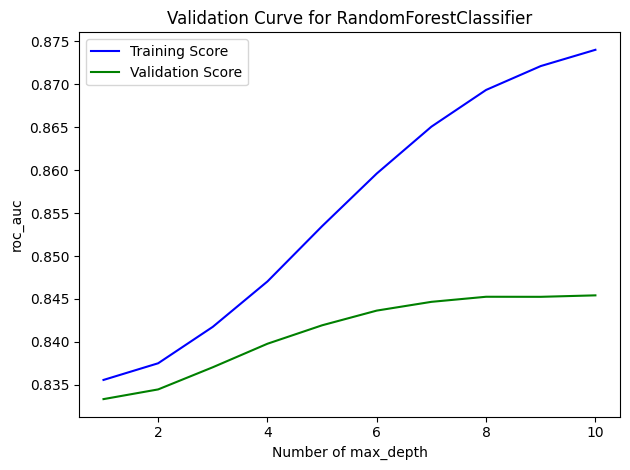

In [87]:
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve

def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

val_curve_params(rf_final, X, y, "max_depth", range(1, 11), scoring="roc_auc")


In [92]:
import pickle
with open('xgboost_pickle.pkl','wb') as f:
    pickle.dump(xgboost_model,f)

with open('rf_pickle.pkl','wb') as f:
    pickle.dump(rf_model,f)

In [89]:
input_data= (
        "Female",0,
"Yes",
"No",
1,
"No",
"No phone service",
"DSL",
"No",
"Yes",
"No",
"No",
"No",
"No",
"Month-to-month",
"Yes",
"Electronic check",
29.85,
"29.85")

In [106]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 69 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  7032 non-null   int64  
 1   Partner                                 7032 non-null   int64  
 2   Dependents                              7032 non-null   int64  
 3   tenure                                  7032 non-null   float64
 4   PhoneService                            7032 non-null   int64  
 5   PaperlessBilling                        7032 non-null   int64  
 6   MonthlyCharges                          7032 non-null   float64
 7   TotalCharges                            7032 non-null   float64
 8   Churn                                   7032 non-null   int64  
 9   NEW_TotalServices                       7032 non-null   int64  
 10  NEW_AVG_Charges                         7032 non-null   floa

In [100]:
print(X.columns.tolist())

['gender', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'NEW_TotalServices', 'NEW_AVG_Charges', 'NEW_AVG_Service_Fee', 'MultipleLines_No_phone_service', 'MultipleLines_Yes', 'InternetService_Fiber_optic', 'InternetService_No', 'OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes', 'OnlineBackup_No_internet_service', 'OnlineBackup_Yes', 'DeviceProtection_No_internet_service', 'DeviceProtection_Yes', 'TechSupport_No_internet_service', 'TechSupport_Yes', 'StreamingTV_No_internet_service', 'StreamingTV_Yes', 'StreamingMovies_No_internet_service', 'StreamingMovies_Yes', 'Contract_One_year', 'Contract_Two_year', 'PaymentMethod_Credit_card_(automatic)', 'PaymentMethod_Electronic_check', 'PaymentMethod_Mailed_check', 'TENURE_CAT_NEW_Very_short', 'TENURE_CAT_NEW_long1', 'TENURE_CAT_NEW_long2', 'TENURE_CAT_NEW_medium1', 'TENURE_CAT_NEW_medium2', 'TENURE_CAT_NEW_medium3', 'MONTHLY_CHARGES_NEW_economy', 'MONTHLY_CHARGES_NEW_platinium